### City power consumption predictor

#### The primary objective of this project is to predict Power consumption of Zone 1, Wellington, New zealand in order to assist in managing energy resource effectively & optimizing power consumption rates.

This involves analyzing various dependent geographical factors listed below. Each factors contributes their own on predicting power consumption in given Zone 1, Wellington.
    
1. Temperature: The temperature in Celsius at the specific location.
2. Humidity: The relative humidity percentage at the location. 
3. Wind Speed: The speed of the wind at the location. 
4. General Diffuse Flows: Refer to a specific measurement or calculation related to the amount or intensity of diffuse solar radiation in a particular area.
5. Diffuse Flows: The measure of diffuse solar radiation. 
6. Air Quality Index: An index representing the air quality in the area.
7. Cloudiness: The level of cloud cover or cloudiness at the location.

Target value to be predicted is Zone 1 Power Consumption in KWR

### Import libraries

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import logging
import os
import sys
from datetime import datetime

### Logging and Exception setup

In [3]:
log_dir = 'logs'
if not os.path.exists(log_dir):
    os.makedirs(log_dir)

log_filename = datetime.now().strftime('%Y-%m-%d_%H-%M-%S') + '.log'
log_filepath = os.path.join(log_dir, log_filename)
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(levelname)s - %(message)s',
    filename=log_filepath
)

In [20]:
class CustomException(Exception):
    def __init__(self,error_message,error_details:sys):
        self.error_message = error_message
        _,_,exc_tb = error_details.exc_info()
        
        self.lineno=exc_tb.tb_lineno
        self.file_name=exc_tb.tb_frame.f_code.co_filename 
    def __str__(self):
        logging.error("Error occured in python script name [{0}] line number [{1}] error message [{2}]".format(
        self.file_name, self.lineno, str(self.error_message)))
        return "Error occured in python script name [{0}] line number [{1}] error message [{2}]".format(
        self.file_name, self.lineno, str(self.error_message))

### Data injestion/loading 

In [23]:
try:
    logging.info(f'Loading data')
    df=pd.read_excel(r'datasets\city-power-consumption.xlsx')
    logging.info(f'Data Loaded successfully')
    df.head(5)
except Exception as ex:
    raise CustomException(ex, sys)

In [3]:
df.shape

(52583, 9)

### Basic Data cleaning

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52583 entries, 0 to 52582
Data columns (total 9 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   S no                          52583 non-null  int64  
 1   Temperature                   52263 non-null  object 
 2   Humidity                      52558 non-null  object 
 3   Wind Speed                    52512 non-null  float64
 4   general diffuse flows         52275 non-null  float64
 5   diffuse flows                 52568 non-null  float64
 6   Air Quality Index (PM)        52565 non-null  float64
 7   Cloudiness                    52583 non-null  int64  
 8    Power Consumption in A Zone  52583 non-null  float64
dtypes: float64(5), int64(2), object(2)
memory usage: 3.6+ MB


- Column names should be renamed
- Data type of temperature and humidity are object. need to convert to float

In [5]:
df.columns

Index(['S no', 'Temperature', 'Humidity', 'Wind Speed',
       'general diffuse flows', 'diffuse flows', 'Air Quality Index (PM)',
       'Cloudiness', ' Power Consumption in A Zone'],
      dtype='object')

In [6]:
# Get column dictionary to rename features to standardize feature names
dict.fromkeys(df.columns)

{'S no': None,
 'Temperature': None,
 'Humidity': None,
 'Wind Speed': None,
 'general diffuse flows': None,
 'diffuse flows': None,
 'Air Quality Index (PM)': None,
 'Cloudiness': None,
 ' Power Consumption in A Zone': None}

In [24]:
# Rename & standardize feature names
new_column_names={'Temperature':'temperature',
                  'Humidity':'humidity',
                  'Wind Speed':'wind_speed', 
                  'general diffuse flows':'general_diffuse_flows',
                  'diffuse flows':'diffuse_flows',
                  'Air Quality Index (PM)':'air_quality_index',
                  'Cloudiness':'cloudiness',
                  ' Power Consumption in A Zone':'power_consumption'}
try:
    logging.info('Renaming columns & dropping S.no column')
    df.rename(columns=new_column_names, inplace=True)
    # Drop non contributing feature S no as its values are unique for each of the row
    df.drop('S no', axis=1, inplace=True)
    logging.info('Renamed columns & dropped S.no column')
except Exception as ex:
    raise CustomException(ex,sys)
df.head(5)

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,air_quality_index,cloudiness,power_consumption
0,6.559,73.8,0.083,0.051,0.119,158.0,1,34055.69620
1,6.414,74.5,0.083,0.070,0.085,159.0,1,29814.68354
2,6.313,74.5,0.080,0.062,0.100,151.0,1,29128.10127
3,6.121,75,0.083,0.091,0.096,151.0,1,28228.86076
4,5.921,75.7,0.081,0.048,0.085,154.0,1,27335.69620


In [8]:
df.tail(5)

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,air_quality_index,cloudiness,power_consumption
52578,NaN,75.6,0.094,436.2,38.96,157.0,0,34444.55696
52579,NaN,73.5,0.089,451.6,37.73,157.0,0,34438.48101
52580,NaN,70.1,0.085,466.4,37.49,157.0,0,33873.41772
52581,NaN,67.75,0.086,477.0,37.37,152.0,0,33988.86076
52582,NaN,66.24,0.088,485.7,36.72,155.0,0,34158.98734


#### Type conversion

In [9]:
# Check what all values are stopping column from converting to float
def return_item(str_item):
    if str(str_item).replace('.','').replace(' ','').isnumeric() or pd.isna(str_item):
        return True
    else:
        return False
df['temperature'][df['temperature'].apply(return_item)==False]

470     5.488 dc
1757    13.65 CD
2287    12.31 dc
Name: temperature, dtype: object

In [10]:
# Type convertion of Temperature column
df['temperature']=df['temperature'].apply(lambda item: str(item).split()[0])
df['temperature']=df['temperature'].astype('float64')

In [11]:
df['humidity'][df['humidity'].apply(return_item)==False]

719    84.8 i
Name: humidity, dtype: object

In [12]:
# Type convertion of humidity column
df['humidity']=df['humidity'].apply(lambda item: str(item).split()[0])
df['humidity']=df['humidity'].astype('float64')

In [13]:
# Check for duplicated
df.duplicated().sum()

np.int64(0)

### Basic EDA

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52583 entries, 0 to 52582
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature            52263 non-null  float64
 1   humidity               52558 non-null  float64
 2   wind_speed             52512 non-null  float64
 3   general_diffuse_flows  52275 non-null  float64
 4   diffuse_flows          52568 non-null  float64
 5   air_quality_index      52565 non-null  float64
 6   cloudiness             52583 non-null  int64  
 7   power_consumption      52583 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.2 MB


In [15]:
df.describe()

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,air_quality_index,cloudiness,power_consumption
count,52263.000000,52558.00000,52512.000000,52275.000000,52568.000000,52565.000000,52583.000000,52583.000000
mean,18.827384,68.28577,1.955320,182.964247,74.872330,154.499191,0.009338,31061.821779
std,5.813293,15.54517,2.347914,264.571351,124.084858,2.871553,0.096180,8021.057455
min,3.247000,11.34000,0.050000,0.004000,0.011000,150.000000,0.000000,9457.750760
25%,14.430000,58.33000,0.078000,0.062000,0.122000,152.000000,0.000000,24738.858990
50%,18.820000,69.88500,0.086000,5.226000,4.412000,155.000000,0.000000,31189.787230
75%,22.910000,81.40000,4.915000,320.100000,100.500000,157.000000,0.000000,36721.582445
max,40.010000,94.80000,6.483000,1163.000000,936.000000,159.000000,1.000000,52204.395120


In [16]:
for col in df.columns:
    print(f"{col}'s unique count is {df[col].nunique()} ")

temperature's unique count is 3436 
humidity's unique count is 4443 
wind_speed's unique count is 548 
general_diffuse_flows's unique count is 10497 
diffuse_flows's unique count is 10449 
air_quality_index's unique count is 10 
cloudiness's unique count is 2 
power_consumption's unique count is 27760 


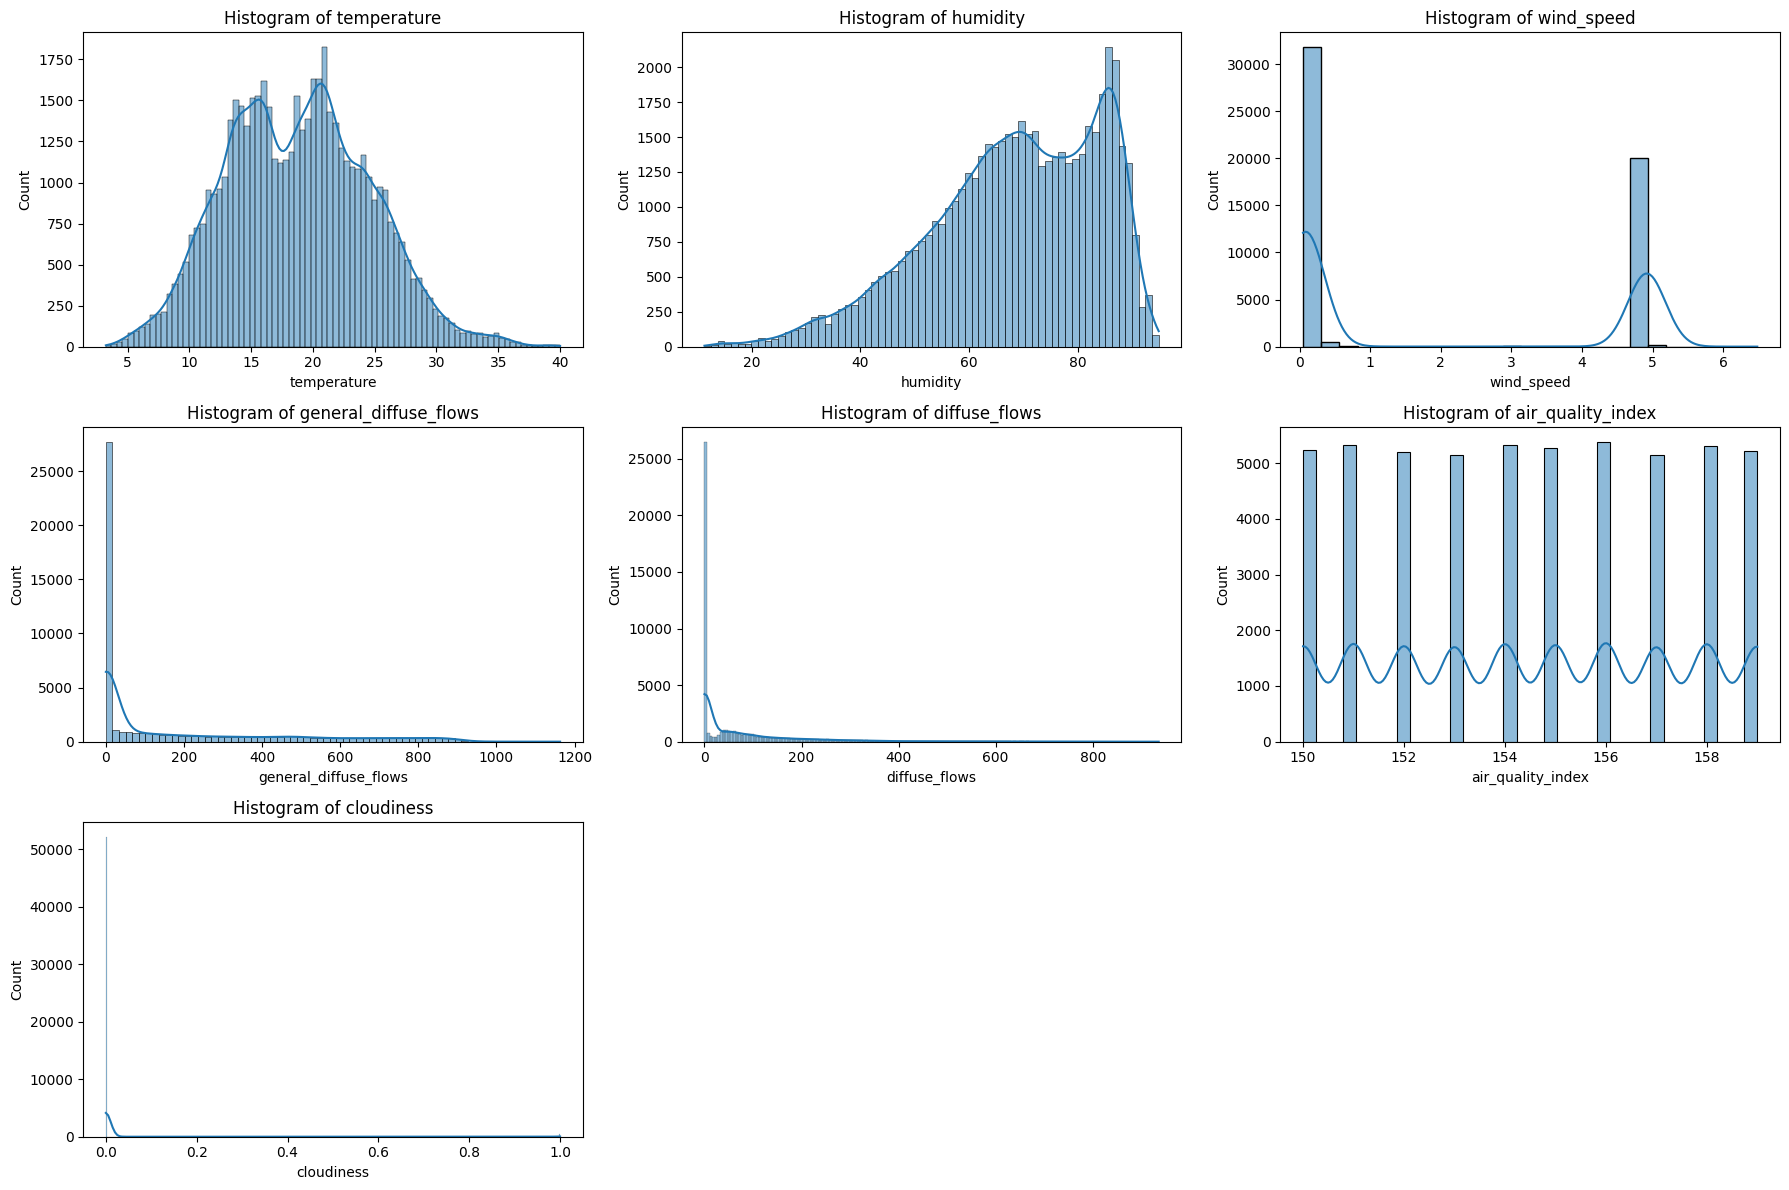

In [59]:
def show_hist_plot():    
    plt.Figure((20,5))
    fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
    axes = axes.flatten()
    for i, col in enumerate(df.columns[:-1]):
        sns.histplot(data=df, x=col, kde=True, ax=axes[i])
        axes[i].set_title(f'Histogram of {col}')

    # Turn off the unused subplots (if any)
    for j in range(len(df.columns[:-1]), len(axes)):
        fig.delaxes(axes[j])

    # Layout adjustment
    plt.tight_layout()
    plt.show()

show_hist_plot()

In [18]:
df.corr()

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,air_quality_index,cloudiness,power_consumption
temperature,1.000000,-0.459839,0.476252,0.460232,0.196059,-0.002658,-0.096498,0.560497
humidity,-0.459839,1.000000,-0.137491,-0.467601,-0.257509,0.003637,0.013557,-0.230305
wind_speed,0.476252,-0.137491,1.000000,0.133807,0.000033,0.000812,-0.069815,0.206273
general_diffuse_flows,0.460232,-0.467601,0.133807,1.000000,0.564636,-0.001430,-0.015500,0.207953
diffuse_flows,0.196059,-0.257509,0.000033,0.564636,1.000000,-0.002009,-0.030159,0.062666
air_quality_index,-0.002658,0.003637,0.000812,-0.001430,-0.002009,1.000000,-0.005792,-0.001039
cloudiness,-0.096498,0.013557,-0.069815,-0.015500,-0.030159,-0.005792,1.000000,-0.120694
power_consumption,0.560497,-0.230305,0.206273,0.207953,0.062666,-0.001039,-0.120694,1.000000


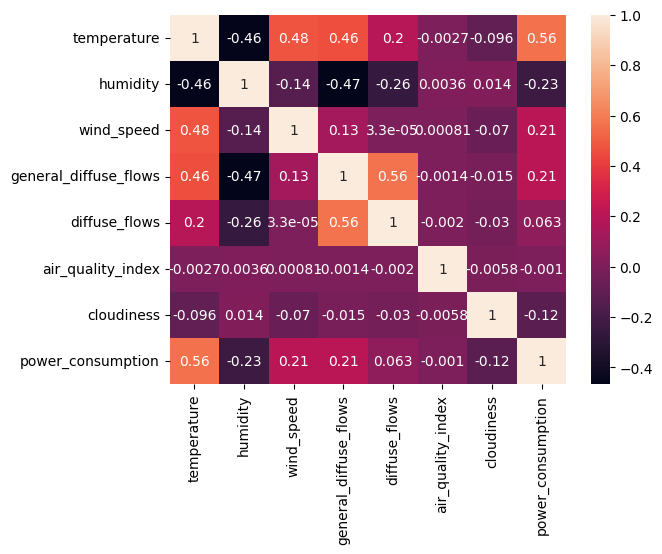

In [19]:
sns.heatmap(df.corr(), annot=True)
plt.savefig(r'artifacts\corr_matrix.png')


### Null checks

In [20]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52583 entries, 0 to 52582
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   temperature            52263 non-null  float64
 1   humidity               52558 non-null  float64
 2   wind_speed             52512 non-null  float64
 3   general_diffuse_flows  52275 non-null  float64
 4   diffuse_flows          52568 non-null  float64
 5   air_quality_index      52565 non-null  float64
 6   cloudiness             52583 non-null  int64  
 7   power_consumption      52583 non-null  float64
dtypes: float64(7), int64(1)
memory usage: 3.2 MB


In [21]:
pd.DataFrame({'Total null count':df.isnull().sum().values, 'Total null %':df.isnull().sum().values/df.shape[0]*100},index= df.columns )

,Total null count,Total null %
temperature,320,0.608562
humidity,25,0.047544
wind_speed,71,0.135025
general_diffuse_flows,308,0.585741
diffuse_flows,15,0.028526
air_quality_index,18,0.034232
cloudiness,0,0.000000
power_consumption,0,0.000000


array([[<Axes: title={'center': 'temperature'}>,
        <Axes: title={'center': 'humidity'}>,
        <Axes: title={'center': 'wind_speed'}>],
       [<Axes: title={'center': 'general_diffuse_flows'}>,
        <Axes: title={'center': 'diffuse_flows'}>,
        <Axes: title={'center': 'air_quality_index'}>],
       [<Axes: title={'center': 'cloudiness'}>,
        <Axes: title={'center': 'power_consumption'}>, <Axes: >]],
      dtype=object)

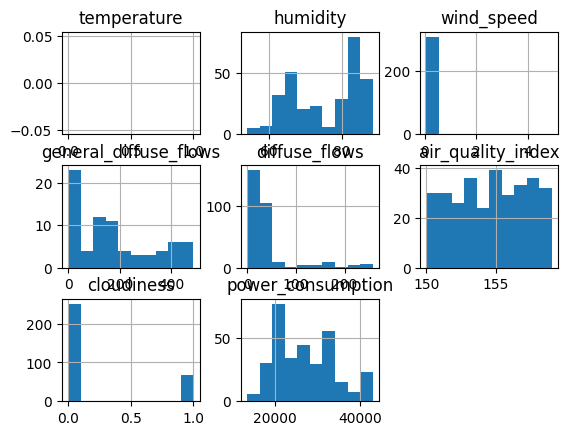

In [22]:
df[df['temperature'].isnull()==True].hist()


--- K-S Test Results ---
K-S Statistic: 0.0030
P-value: 0.9676


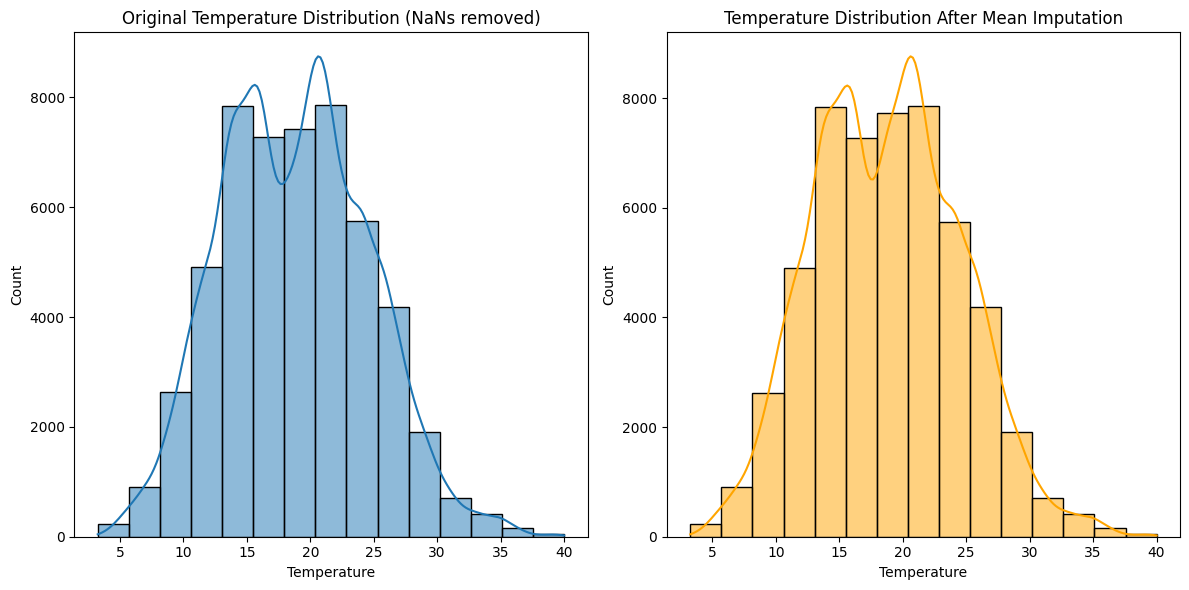

In [23]:
# Check if mean imputation changes distribution of data
original_temperature=df['temperature'].dropna()
imputed_temerature_data=df['temperature'].fillna(df['temperature'].mean())
statistic, p_value = stats.ks_2samp(original_temperature, imputed_temerature_data)
print("\n--- K-S Test Results ---")
print(f"K-S Statistic: {statistic:.4f}")
print(f"P-value: {p_value:.4f}")
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(original_temperature, kde=True, bins=15)
plt.title('Original Temperature Distribution (NaNs removed)')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.subplot(1, 2, 2)
sns.histplot(imputed_temerature_data, kde=True, bins=15, color='orange')
plt.title('Temperature Distribution After Mean Imputation')
plt.xlabel('Temperature')
plt.ylabel('Count')
plt.tight_layout()
plt.show()

In [24]:
# Since temperature data looks like MCAR, filling null values by its mean value as distibution is not changing and is almost symmentric
df['temperature']=df['temperature'].fillna(df['temperature'].mean())

In [25]:
# Replacing humidity null values by its mode as data is less and skewed to left
df['humidity']=df['humidity'].fillna(df['humidity'].mode()[0])

In [26]:
# Replacing wind_speed null values by its mode as data is less and right skewed
df['wind_speed']=df['wind_speed'].fillna(df['wind_speed'].mode()[0])

# Replacing general_diffuse_flows null values by its mode as data is less and right skewed
df['general_diffuse_flows']=df['general_diffuse_flows'].fillna(df['general_diffuse_flows'].mode()[0])

# Replacing diffuse_flows null values by its mode as data is less and right skewed
df['diffuse_flows']=df['diffuse_flows'].fillna(df['diffuse_flows'].mode()[0])

# Replacing air_quality_index null values by its mode as data is less uniformly distributed
df['air_quality_index']=df['air_quality_index'].fillna(df['air_quality_index'].mode()[0])


# No distributions are changed in this imputations

In [27]:
df.isnull().sum()

temperature              0
humidity                 0
wind_speed               0
general_diffuse_flows    0
diffuse_flows            0
air_quality_index        0
cloudiness               0
power_consumption        0
dtype: int64

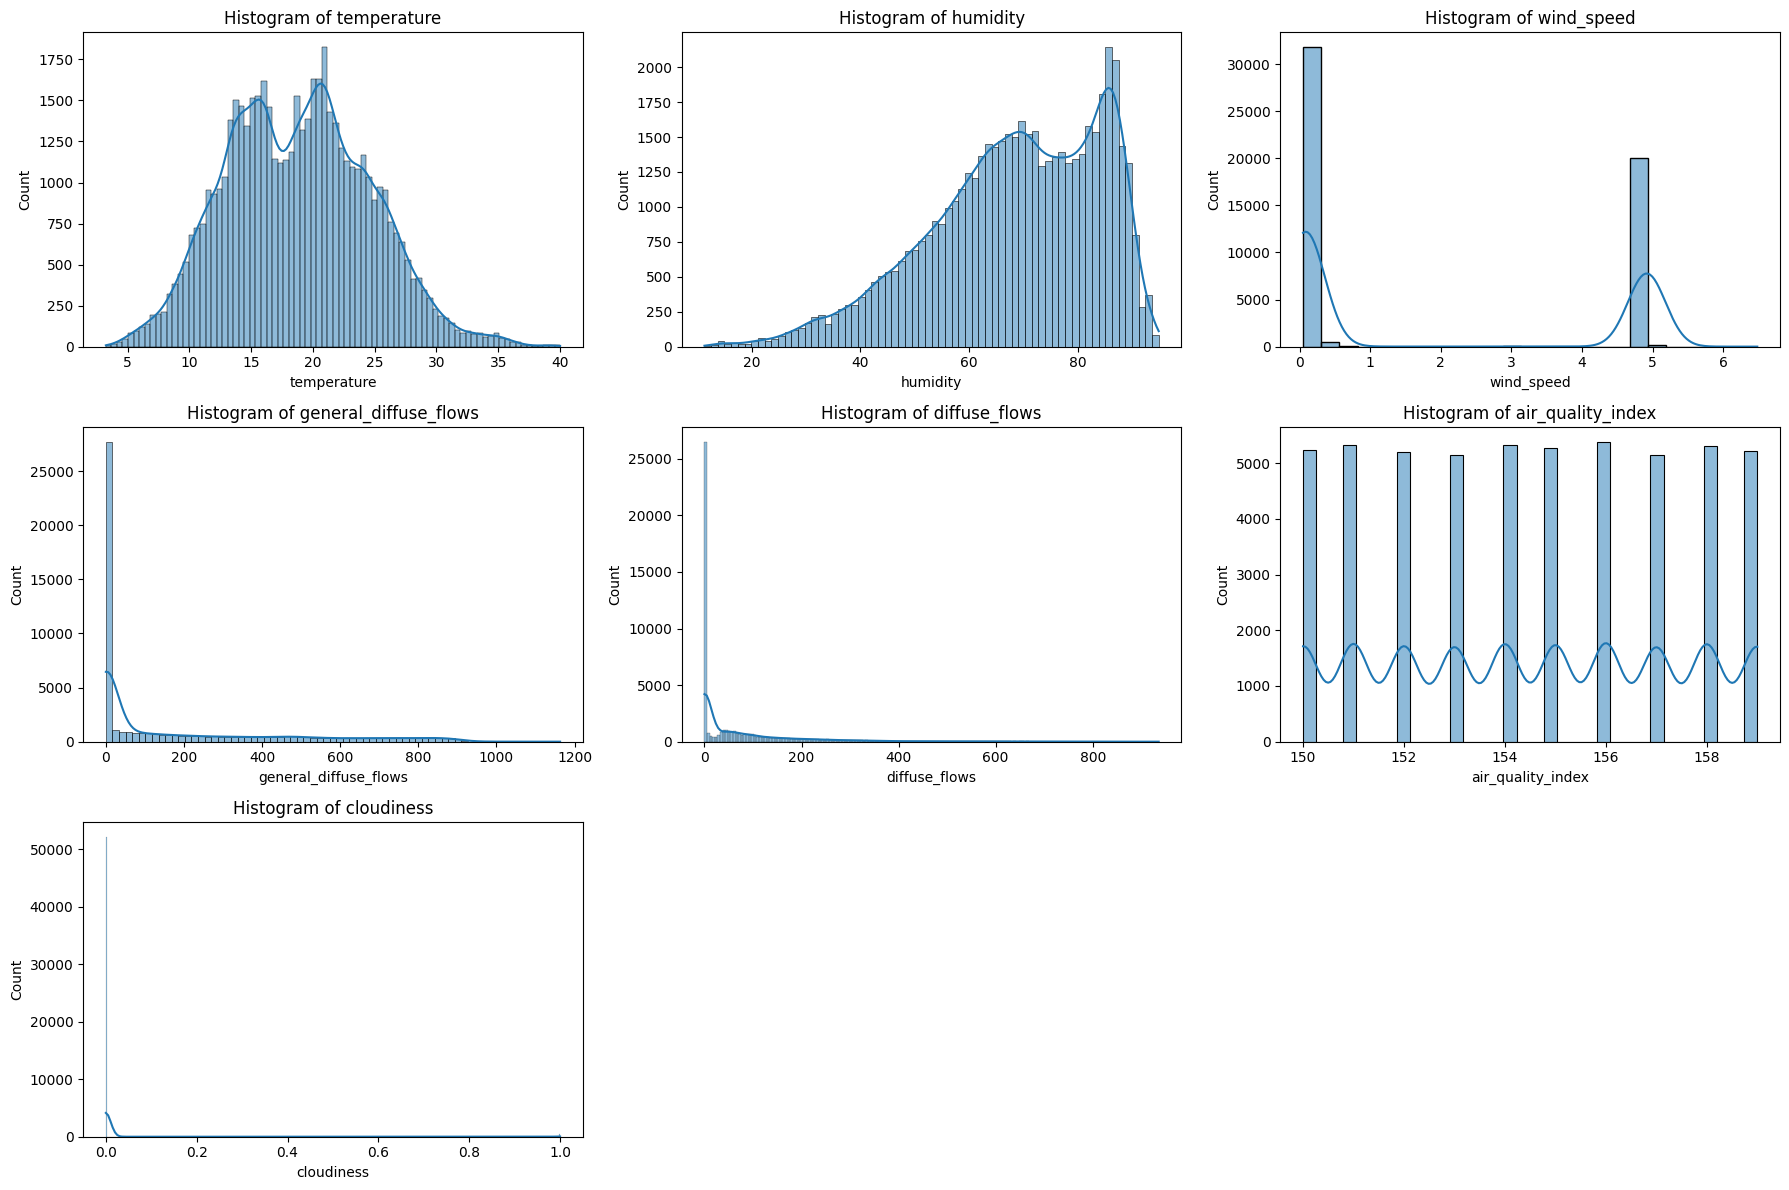

<Figure size 640x480 with 0 Axes>

In [28]:
show_hist_plot()
plt.savefig(r'artifacts\histplot_after_handling_null.png')

### EDA

In [29]:
df.describe()

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,air_quality_index,cloudiness,power_consumption
count,52583.000000,52583.000000,52583.000000,52583.000000,52583.000000,52583.000000,52583.000000,52583.000000
mean,18.827384,68.294144,1.952790,181.892874,74.851004,154.499705,0.009338,31061.821779
std,5.795577,15.546216,2.347337,264.164353,124.073581,2.871196,0.096180,8021.057455
min,3.247000,11.340000,0.050000,0.004000,0.011000,150.000000,0.000000,9457.750760
25%,14.450000,58.340000,0.078000,0.062000,0.122000,152.000000,0.000000,24738.858990
50%,18.827384,69.890000,0.086000,4.326000,4.383000,155.000000,0.000000,31189.787230
75%,22.870000,81.500000,4.915000,317.000000,100.450000,157.000000,0.000000,36721.582445
max,40.010000,94.800000,6.483000,1163.000000,936.000000,159.000000,1.000000,52204.395120


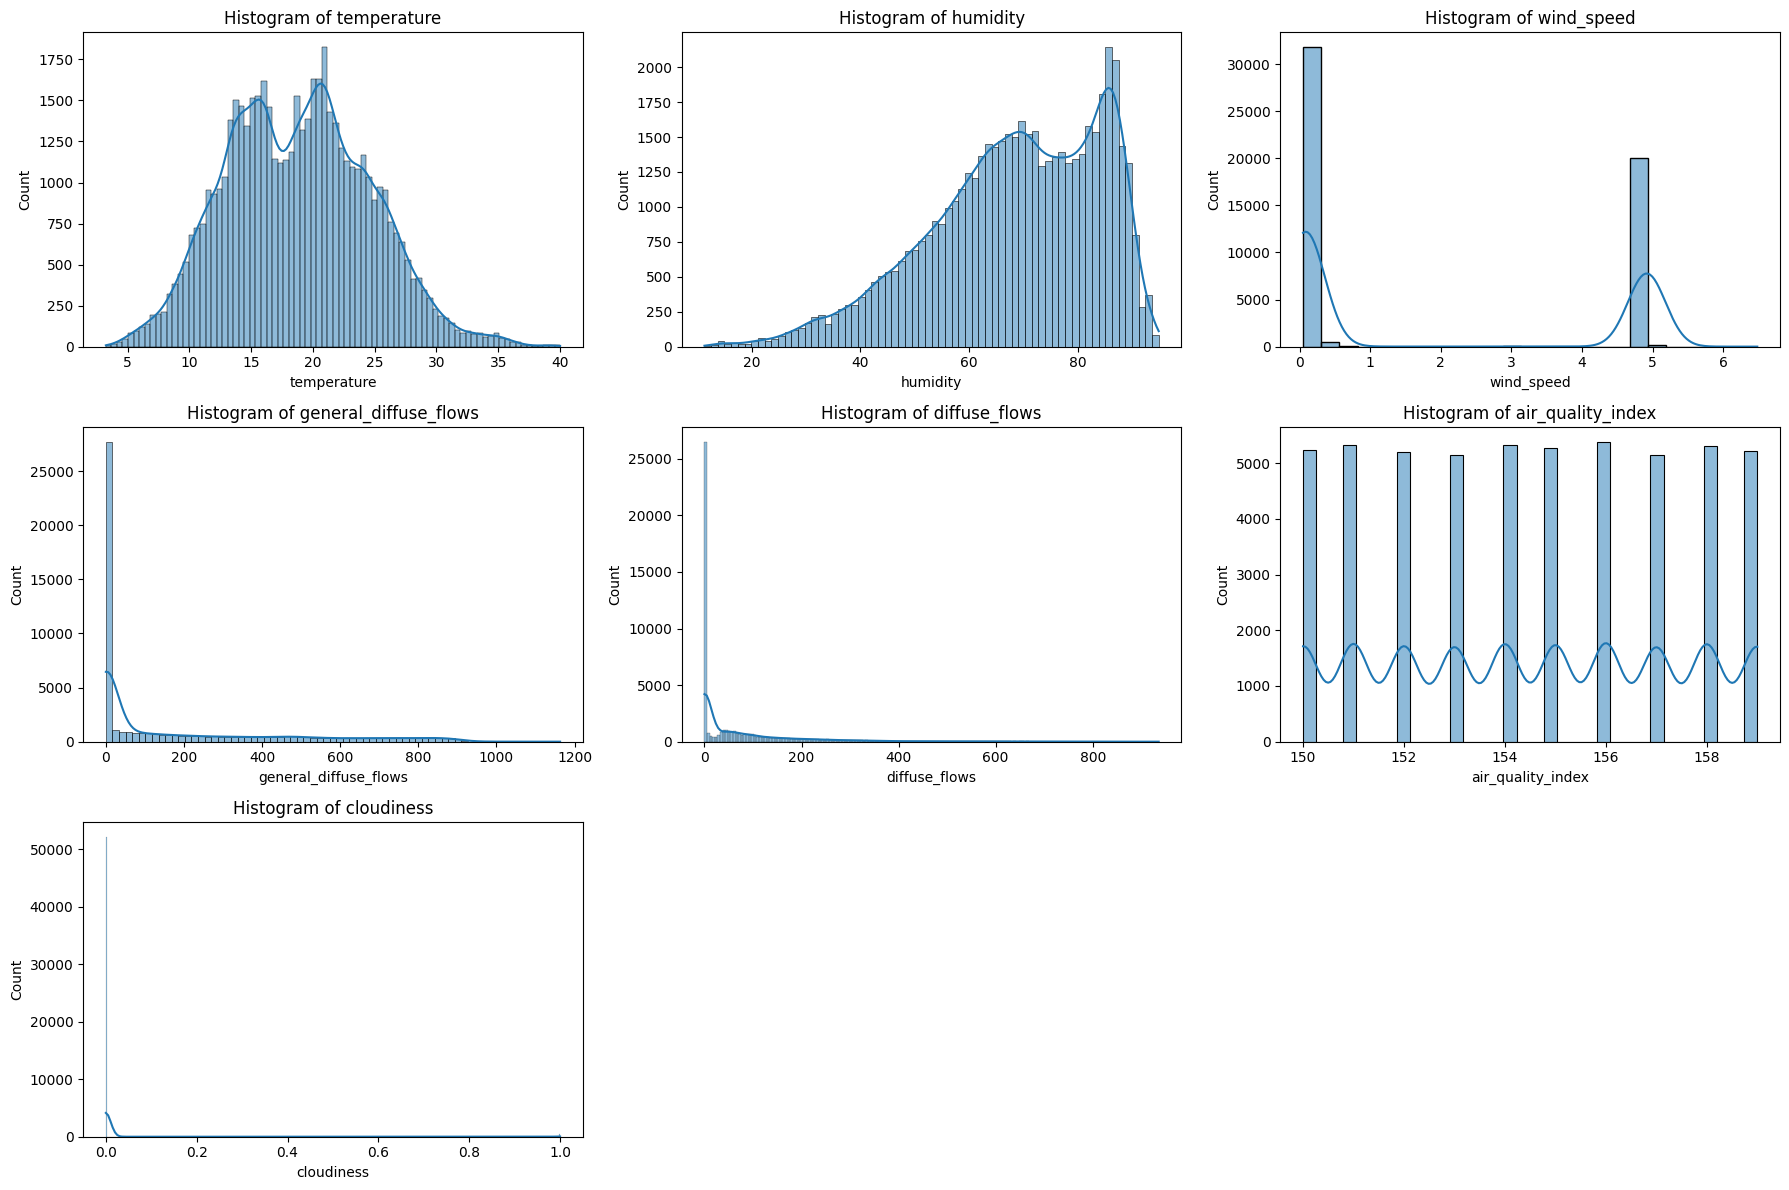

In [30]:
# Univariate analysis
show_hist_plot()

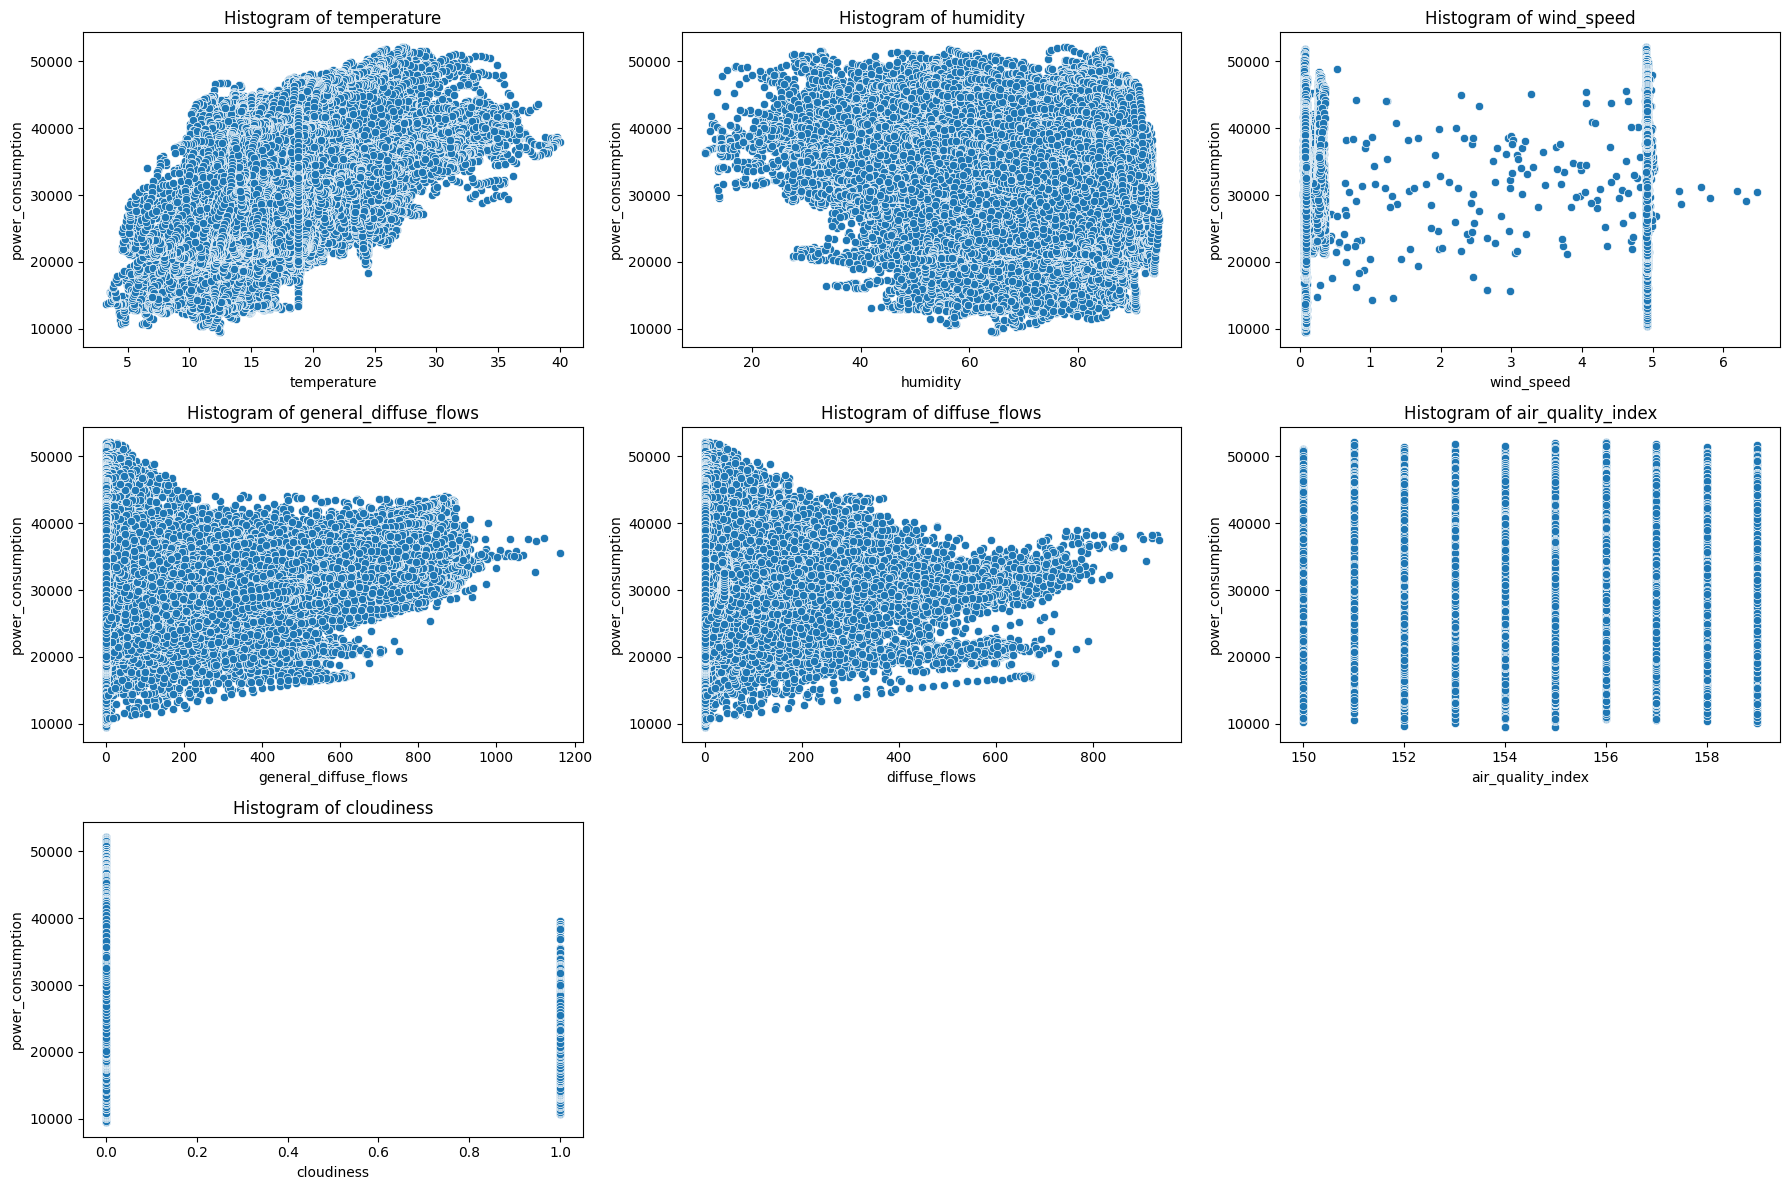

In [31]:
# Bivariate analysis
plt.Figure((20,5))
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(df.columns[:-1]):
    sns.scatterplot(df, x=df[col], y=df['power_consumption'], ax=axes[i])
    axes[i].set_title(f'Histogram of {col}')
# Turn off the unused subplots (if any)
for j in range(len(df.columns[:-1]), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [32]:
# sns.pairplot(df)

#### According to graph/plot of all the features, below are few observations
- Temperature data is bimodal kind of distribution where we can see two spikes and kind of symmetric distribution of data 3-40
- Humidity is left skewed data ranging from 11 to 95
- Wind_speed, general_diffuse_flows, diffuse_flows has extrreme right skewed data
- air_quality_index is distributed normally accros all values.
- cloudiness looks like highly imbalanced which my contribute to bias of model performance. Ratio is approx 10:1
- Temperature has correlation with target which can contribute in predicting target variable power consumption
- Humidity has slight negetive corr with power consumtion which is unusual
- Wind speed spikes at 0 and 5 at all possible patterns related to other features
- Diffuse flow shows that poer consumption is high when there is less diffusion radiations. Might be because of direct sunray falls


### Outlier analysis

In [ ]:
def calculate_outlier_count(columns):
    try:
        for col in columns:
            first_quartile, mean, third_quartile=df[col].quantile([.25, .5, .75])
            IQR=third_quartile-first_quartile
            min_val=round(first_quartile-1.5*IQR,2)
            max_val=round(third_quartile+1.5*IQR,2)
            outlier_count=len(df[(df[col]<min_val) | (df[col]>max_val)])
            print(f"Column {col}'s Min val is {min_val}, Max val is {max_val} and outlier count is {outlier_count}")
    except Exception as ex:
        print()

calculate_outlier_count(df.columns[:-2])

Column temperature's Min val is 1.82, Max val is 35.5 and outlier count is 154
Column humidity's Min val is 23.6, Max val is 116.24 and outlier count is 288
Column wind_speed's Min val is -7.18, Max val is 12.17 and outlier count is 0
Column general_diffuse_flows's Min val is -475.34, Max val is 792.41 and outlier count is 2425
Column diffuse_flows's Min val is -150.37, Max val is 250.94 and outlier count is 4621
Column air_quality_index's Min val is 144.5, Max val is 164.5 and outlier count is 0


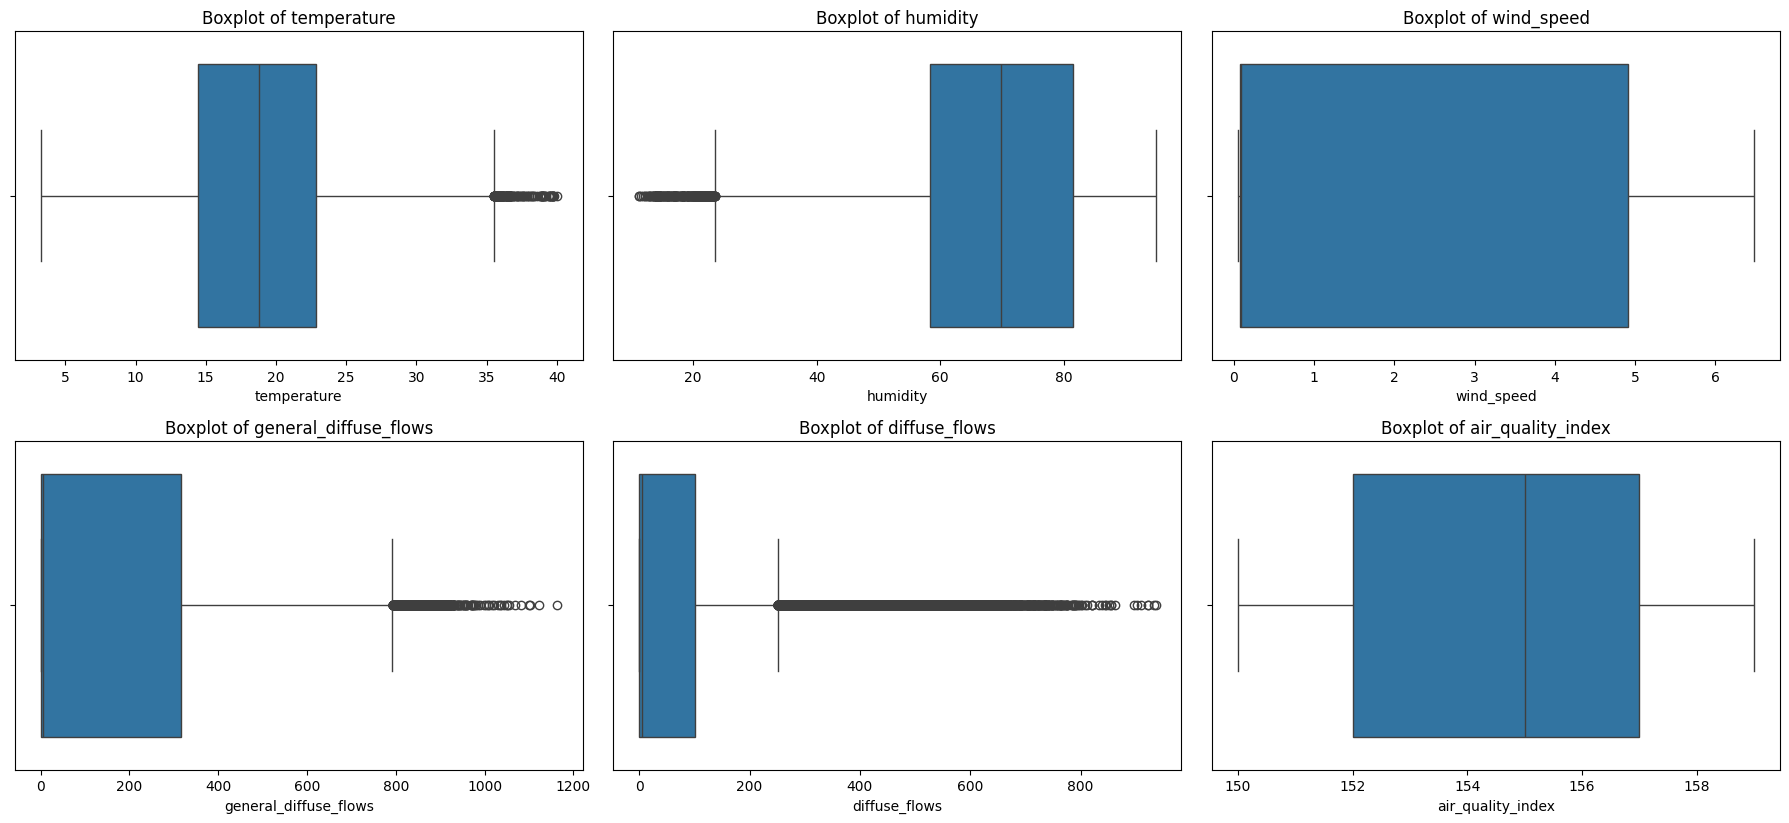

In [34]:
plt.Figure((20,5))
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(18, 12))
axes = axes.flatten()
for i, col in enumerate(df.columns[:-2]):
    sns.boxplot(df, x=df[col], ax=axes[i])
    axes[i].set_title(f'Boxplot of {col}')
# Turn off the unused subplots (if any)
for j in range(len(df.columns[:-2]), len(axes)):
    fig.delaxes(axes[j])
plt.tight_layout()
plt.show()

In [58]:
df[(df['temperature']<1.82) | (df['temperature']>35.5)]

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,air_quality_index,cloudiness,power_consumption
27000,35.78,27.88,4.921,841.0,94.4,158.0,0,29444.25249
27001,36.21,26.75,4.923,850.0,94.7,159.0,0,32799.46844
27002,36.37,26.71,4.922,855.0,95.3,150.0,0,36716.01329
27003,36.69,26.52,4.920,860.0,95.7,158.0,0,36422.59136
27004,36.59,31.89,4.925,862.0,96.2,150.0,0,36129.16944
...,...,...,...,...,...,...,...,...
32058,35.66,21.81,4.902,723.0,139.4,153.0,0,39220.42175
32059,35.64,21.94,4.905,706.0,137.7,155.0,0,39105.34961
32070,35.61,19.04,4.908,446.5,156.7,159.0,0,37475.16093
32071,35.58,18.71,4.906,427.9,204.2,154.0,0,37558.26859


In [44]:
from sklearn.preprocessing import QuantileTransformer
# Initialize transformer
qt = QuantileTransformer(output_distribution='normal', random_state=0)

# Transform the data
transformed = qt.fit_transform(df[['temperature']])

# View result
print(pd.DataFrame(transformed, columns=['feature_percentile']))

       feature_percentile
0               -2.387004
1               -2.442102
2               -2.470629
3               -2.516344
4               -2.568543
...                   ...
52578            0.000000
52579            0.000000
52580            0.000000
52581            0.000000
52582            0.000000

[52583 rows x 1 columns]


In [45]:
df2=pd.DataFrame(transformed, columns=['feature_percentile'])

<Axes: xlabel='feature_percentile', ylabel='Count'>

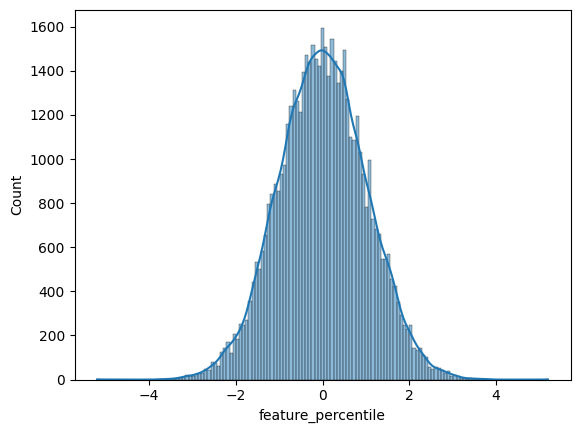

In [46]:
sns.histplot(df2, x=df2['feature_percentile'], kde=True)

<Axes: xlabel='feature_percentile'>

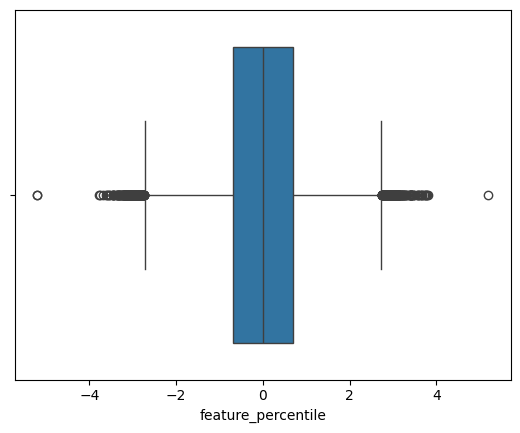

In [47]:
sns.boxplot(df2, x=df2['feature_percentile'])

In [ ]:
from scipy.stats import boxcox
transformed_value, lambda_optimal = boxcox(df['general_diffuse_flows'])

In [ ]:
df['Value_log']=transformed_value
calculate_outlier_count(['Value_log'])

Column Value_log's Min val is -15.34, Max val is 17.98 and outlier count is 0


<Axes: ylabel='Count'>

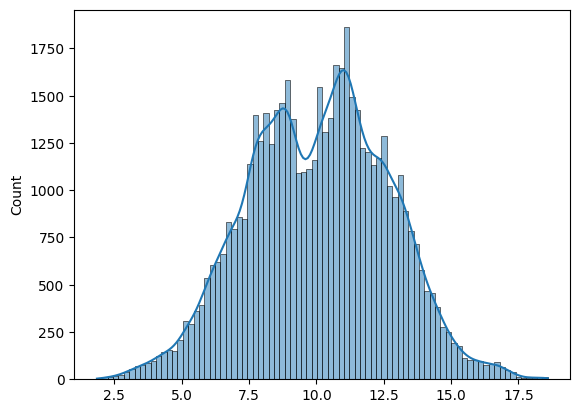

In [ ]:
sns.histplot(df, x=transformed_value, kde=True)

<Axes: xlabel='Value_log', ylabel='Count'>

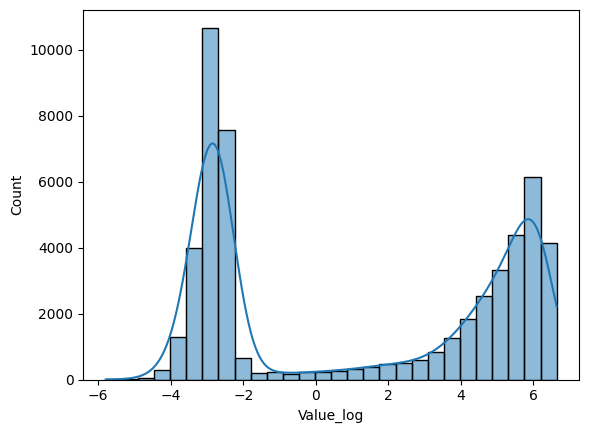

In [ ]:
sns.histplot(data=df, x=df['Value_log'], kde=True)

<Axes: xlabel='general_diffuse_flows', ylabel='Count'>

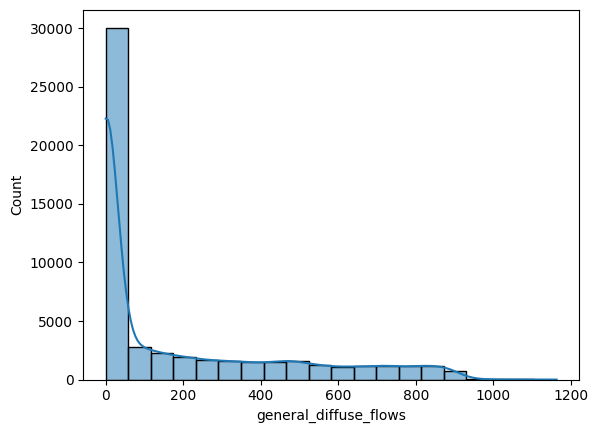

In [ ]:
sns.histplot(data=df, x=df['general_diffuse_flows'], kde=True, bins=20)

In [ ]:
df[(df['general_diffuse_flows']>0) &(df['general_diffuse_flows']<1)]

,temperature,humidity,wind_speed,general_diffuse_flows,diffuse_flows,air_quality_index,cloudiness,power_consumption,Value_log
0,6.559000,73.8,0.083,0.051,0.119,158.0,1,34055.69620,-3.053852
1,6.414000,74.5,0.083,0.070,0.085,159.0,1,29814.68354,-2.721367
2,6.313000,74.5,0.080,0.062,0.100,151.0,1,29128.10127,-2.848573
3,6.121000,75.0,0.083,0.091,0.096,151.0,1,28228.86076,-2.447275
4,5.921000,75.7,0.081,0.048,0.085,154.0,1,27335.69620,-3.117712
...,...,...,...,...,...,...,...,...,...
52553,18.827384,87.4,0.091,0.070,0.137,150.0,0,24030.37975,-2.721367
52554,18.827384,86.9,0.090,0.070,0.122,157.0,0,23763.03797,-2.721367
52555,18.827384,86.7,0.089,0.110,0.119,158.0,0,23605.06329,-2.249951
52556,18.827384,86.9,0.085,0.146,0.226,155.0,0,24066.83544,-1.956526
